In [ ]:
import sys
from pathlib import Path

from IPython.display import Audio

src_path = Path("..")
sys.path.append(str(src_path.resolve()))

# Pipeline из  VAD -> ASR -> MT -> TTS

### Задача

Разработка полного pipeline для автоматического дубляжа видео с использованием моделей автоматического распознавания речи (ASR), машинного перевода (MT) и синтеза речи (TTS).

### Архитектура pipeline

1. **Извлечение аудиодорожки** из оригинального видеофайла.
2. **Разбиение аудиофайла на фрагменты**:
   - Используется библиотека `pydub` для разбиения по длительным паузам (например, тишина > 0.5 сек).
3. **Выделение сегментов речи (VAD)**:
   - Применяется Voice Activity Detection модель `silero_vad` для определения участков с речью.
4. **ASR (Automatic Speech Recognition)**:
   - Распознавание английской речи с помощью модели `whisper-large`.
5. **Машинный перевод (MT)**:
   - Перевод распознанного текста с английского на русский с помощью модели `Helsinki-NLP/opus-mt-en-ru`.
6. **TTS (Text-to-Speech)**:
   - Синтез русской речи на основе переведённого текста с помощью модели `xTTSv2`.
7. **Выравнивание аудио по таймингам**:
   - Аудиофрагменты синтезированной речи выравниваются по временным меткам оригинальной речи.
8. **Постобработка аудио**:
   - Приведение синтезированного звука к нужному формату (громкость, частота дискретизации и т.д.).
9. **Наложение аудио на видео**:
   - Замена оригинальной аудиодорожки в видео на синтезированную.

### Используемые модели

- **VAD**: [`silero_vad`](https://github.com/snakers4/silero-vad) — детекция участков с речью.
- **ASR**: [`whisper-large`](https://github.com/openai/whisper) — распознавание английской речи.
- **MT**: [`Helsinki-NLP/opus-mt-en-ru`](https://huggingface.co/Helsinki-NLP/opus-mt-en-ru) — перевод с английского на русский.
- **TTS**: [`xTTSv2`](https://github.com/coqui-ai/TTS) — синтез русской речи с сохранением интонации.

### Реализация

Код проекта организован следующим образом:

- Все скрипты находятся в директории `src/`.
- Конфигурационные параметры — в файле `config/config.yaml`.

### Основные технические трудности и решения

При построении pipeline возникло несколько ключевых технических проблем:

1. **Некачественное разбиение на чанки при использовании временных меток из ASR**  
   Использование таймингов от `whisper` приводило к тому, что чанки часто заканчивались посреди предложения. Это снижало качество машинного перевода, поскольку модели требовался полный контекст.  
   **Решение**: вместо этого было реализовано разбиение по паузам с помощью `pydub`, что позволило выделять более естественные фразы.

2. **Удаление пауз при разбиении по тишине**  
   При использовании стандартного метода `split_on_silence` из `pydub` паузы между фразами терялись, из-за чего итоговая длина аудио становилась меньше оригинала, и нарушалась синхронизация.  
   **Решение**: использовалась функция `detect_nonsilent`, которая сохраняет границы фрагментов, включая тишину, обеспечивая более точное восстановление длительности.

3. **Увеличение длительности синтезированной русской речи**  
   Русские переводы зачастую оказывались длиннее английских оригиналов, что приводило к смещению таймингов.  
   **Решение**: применялось растяжение/сжатие аудио (`time-stretching`) с помощью `librosa` и `torchaudio.sox_effects`, чтобы подогнать длительность под исходные сегменты.

4. **Потеря качества звука при использовании librosa для time-stretching**  
   Даже при незначительном изменении скорости `librosa` искажала голос — он становился металлическим или артефактным.  
   **Решение**: переход на `torchaudio.sox_effects`, который обеспечил более высокое качество обработки.

5. **Выравнивание русской и английской речи по таймингам**  
   Важно было сохранить синхронность переведённой речи с визуальным рядом. Использовались различные подходы:
   - глобальный time-stretch на весь аудиофрагмент,
   - использованиия моделей # TODO: дописать модели
   - покадровая адаптация по чанкам,
   - выравнивание по сегментам речи (VAD).  
   **Решение**: комбинированный подход в зависимости от длины и структуры фраз (в процессе уточнения и экспериментов).  
   `# TODO`: провести количественную оценку качества синхронизации и завершить подбор оптимальной стратегии.

### Нерешенные проблемы

- Выравнивание речи. Хоть и предпринималось достаточно много попыток по улучшению, результат остается далек от желаемого.
- Дополнительная постобработка: голос все равно ощущается синтезированным.
- Дообучения модели xTTSv2 на БОЛЬШОМ объеме данных.


### Возможные улучшения

- Допилить выравнивание речи.
- Добавить предобработки (шумоподавление, нормализация).
- Завернуть в контейнер.
- API

Выбор референса для zero-shot: **Владимир Зайцев** (Железный человек, Джокер)

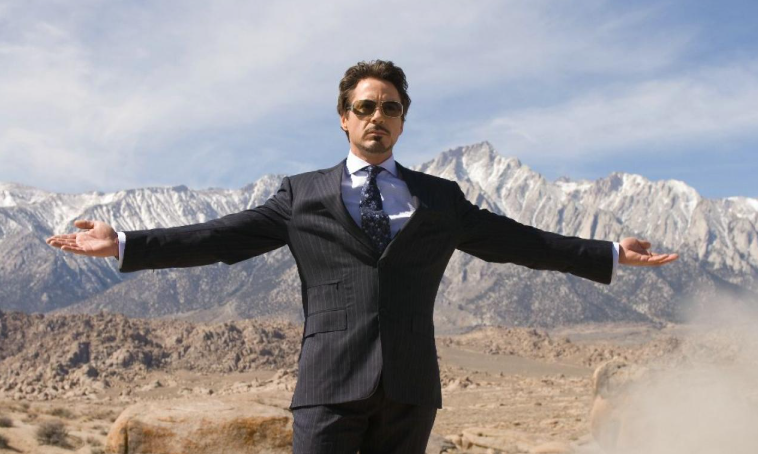

In [3]:
from pydub import AudioSegment

SAMPLE_REFERENCE = "../data/speaker_sample.wav"

speaker_sample = AudioSegment.from_file(SAMPLE_REFERENCE)
speaker_sample

In [ ]:
from src.pipeline import VideoDubPipe

pipe = VideoDubPipe("../config/config.yaml")

# Moдель xTTSv2

### Архитектура

Ссылка на [`статью`](https://arxiv.org/pdf/2406.04904).

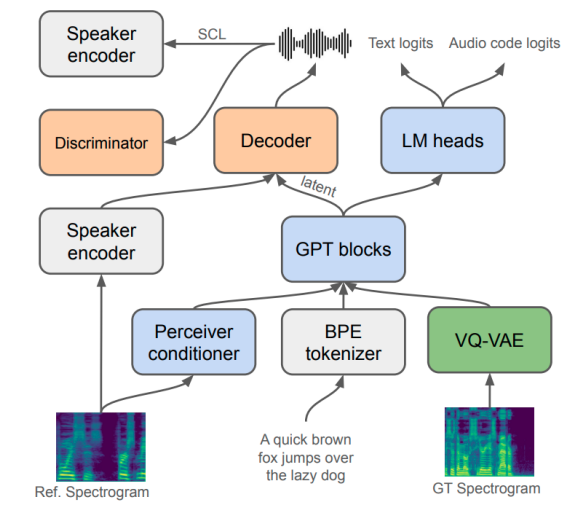


## Входы и выходы модели

### Входы:
- **Текст** (в любом из 17 поддерживаемых языков, но с ограничениями по длине. Для русского ограничения в 182 символа).
- **Аудио-референс** (WAV, 22.5 kHz), из которого извлекается speaker embedding.

### Процесс:
- Текст → токенизация (BPE) (на выходе токены n х 6681, где n число токенов).
- Аудио → mel-спектрограмма → speaker embedding через Conditioning Encoder (на выходе 32х1024 эмбеддинга).
- GPT-2 (GPT blocks) предсказывает VQ-токены, представляющие аудио на уровне скрытых представлений.
- Полученные токены описывают сжатую версию мел-спектрограммы (note: на инференсе явное декодирование через VQ-VAE не происходит).
- Decoder (HiFi-GAN) преобразует их в 24 kHz аудио (на входе скрытые представления из GPT-2, а не VQ-VAE потому, что последнее вызывало артефакты).
- В каждом слое Decoder (HiFi-GAN) также на вход подаются speaker embedding для сохранения голосовых характеристик.

### Выход:
- **Синтезированный WAV файл** (24 kHz), имитирующий голос референсного спикера.

---


## Основные архитектурные блоки

1. **VQ-VAE Encoder**
   - Преобразует мел-спектрограмму в дискретные аудио токены.
   - Использует 1 кодбук с 8192 кодами (на инференсе используются 1024 наиболее частотных).
   - Частота токенов: 21.53 Hz (в отличие от 75 Hz в VALL-E).

2. **Conditioning Encoder (Speaker Encoder)**
   - Принимает референсное аудио.
   - Состоит из 6 слоёв Multi-head Attention + Perceiver Resampler.
   - Генерирует 32 вектора размерностью 1024 для speaker conditioning.

3. **GPT-2 Decoder**
   - Transformer decoder-only архитектура с 443M параметров.
   - Принимает BPE-токены текста и speaker embeddings.
   - Предсказывает последовательность VQ аудио-токенов.

4. **HiFi-GAN Vocoder**
   - Генерирует финальный WAV из скрытых представлений GPT-2.
   - Использует speaker embedding на каждом слое upsampling.

---

## Ключевые особенности

- **Zero-shot Voice Cloning** — небольшое аудио достаточно для клонирования голоса.
- **Cross-lingual Synthesis** — мультиязычность (хотя и с некоторыми ограничениями).
- **Speaker Interpolation** — возможность смешивать несколько голосов.
- **Высокое качество аудио** — 24 kHz, улучшенная просодия, стабильность.

---

### Zero Shot

In [2]:
# использую готовую обертку на xTTSv2
from src.tts import XTTSv2

tts_model = XTTSv2()  # используется дефолтная xTTSv2 модель

/home/alexbarrow/proj/video-dubbing-dls-project/.venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
audio1 = tts_model.tts(
    text="Кое что мне известно. Правда не то, что хотелось бы.",
    speaker_wav=SAMPLE_REFERENCE,
    speed=1.2,
    temperature=0.4,
    repetition_penalty=15.0,
    length_penalty=25,
)

The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [53]:
Audio(audio1, rate=24000)

In [ ]:
# Пробуем несколько сэмплов:
audio2 = tts_model.tts(
    text="Кое что мне известно. Правда не то, что хотелось бы.",
    speaker_wav=[
        SAMPLE_REFERENCE,
        "../data/train_data/wavs/sample5.wav",
        "../data/train_data/wavs/sample37.wav",
    ],
    speed=1.2,
    temperature=0.4,
    repetition_penalty=15.0,
    length_penalty=25,
)

The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.
The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [60]:
Audio(audio2, rate=24000)

### Выводы:

- Модель достаточно неустойчева (возможно, не удачный текст выбран или сэмплы), но при перезапуске на одних и тех же параметрах с теми же референсами, выдает достаточно разный результат.
- Несмотря на warning про length_penalty, модель при повышении генерирует более сжато.
- В данном случаее модель генерирует большие паузы между предложений и иногда галюцинирует. 

In [ ]:
### Попробуем на одном предложении:
audio3_os = tts_model.tts(
    text="Я очень хочу понять как работает данная модель, но мне многое остается не ясным.",
    speaker_wav=SAMPLE_REFERENCE,
    speed=1.2,
    temperature=0.4,
    repetition_penalty=15.0,
    length_penalty=10,  # уменьшить значения, чтобы не было скороговорок
)

Audio(audio3_os, rate=24000)

The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


In [ ]:
### Попробуем на одном предложении:
audio4_os = tts_model.tts(
    text="Я очень хочу понять как работает данная модель, но мне многое остается не ясным.",
    speaker_wav=[
        SAMPLE_REFERENCE,
        "../data/train_data/wavs/sample5.wav",
        "../data/train_data/wavs/sample37.wav",
    ],
    speed=1.2,
    temperature=0.4,
    repetition_penalty=15.0,
    length_penalty=10,  # уменьшить значения, чтобы не было скороговорок
)

Audio(audio4_os, rate=24000)

The following generation flags are not valid and may be ignored: ['length_penalty']. Set `TRANSFORMERS_VERBOSITY=info` for more details.


### Итог:
- Следует генерировать короткими предложениями, а далее их объединять. Иначе модель генерирует слишком большие паузы
- Очень чувствительна к референсам.
- Очень чувствительна к seed. От раза к разу результат меняется значительно.


# Fine-tuning

## Few-Shot Voice Cloning с XTTSv2

### Задача

Провести fine-tuning модели XTTSv2. (`notebooks/trainer.ipynb`)

Для этого необходимо собрать набор данных с нужным спикером и дообучить модель XTTSv2. (`notebooks/dataset.ipynb`)

### Сбор данных

Готовых датасетов под нужного спикера не нашлось, поэтому пришлось резать аудио самому.

- Количество собранных сэмплов: **46 аудио файлов**
- Длины сэмплов: переменные (от коротких до длинных фраз, 1-12 сек)

### Основные проблемы подхода

1. **Мало данных**  
   Ограниченные сроки не позволили собрать достаточно данных.  
   Для полноценного fine-tune требуется больше материала (желательно ≥ 10 минут чистой речи).

2. **Нерегулярное распределение длин**  
   Сэмплы разной длины, что может вызывать проблемы при обучении.  
   Кроме того, длина сэмплов отличается от референсов, используемых на инференсе.

3. **Шумы и артефакты в данных**  
   Поскольку данные взяты из фильма, в них присутствуют посторонние звуки (фон, музыка, эффекты).  
   Для очистки применялись:
   - Нормализация
   - Denoising  
   
   Однако гиперпараметры denoiser были подобраны недостаточно точно:
   - Местами речь сильно обрезалась.
   - Шумы частично остались в некоторых фрагментах.
   - Требуется более аккуратная настройка.

### Результаты

Fine-tune особо не помог, а иногда даже ухудшал качество по сравнению с ванильной XTTSv2.

Обучено 2 чекпоинта (будет добавлено уточнение по метрикам).  
**# TODO: дополнить информацию о конкретных параметрах обучения и результатах.**

---

### Возможные улучшения

Собрать полноценный pipeline для выделения речи. Примерная cтруктура pipeline следующая:

#### 1. **Выделение речи нужного спикера**

- Использовать **Speaker Diarization**:
  - VAD (Voice Activity Detection)
  - Сегментация аудио по говорящим
  - Кластеризация спикеров

- Либо **Speaker Identification** (если известен целевой спикер):
  - Поиск и отбор только тех сегментов, где говорит нужный человек.

#### 2. **Постобработка**

- Аудио нормализация
- Точная настройка denoiser (с подбором порогов для конкретных записей)
- Фильтрация оставшихся шумов (при необходимости)

#### 3. **Подготовка к обучению**

- Результирующие чистые сегменты можно разбить на оптимальные по длине подсегменты.
- Использовать их для fine-tune XTTSv2 на задачу voice cloning.

---

### Ожидаемый результат

На выходе ожидаем получить сегменты с речью нужного спикера, а далее можно нарезать на нужного размера подсегменты и использовать их для обучения xTTSv2. 

### Результат finetune

In [ ]:
chp1 = XTTSv2()  # init checkpoint
chp2 = XTTSv2()  # init checkpoint


# Метрики